In [1]:
import numpy as np
import cv2
import mahotas
from matplotlib import pyplot as plt
%matplotlib inline 
plt.rcParams['figure.figsize'] = 15, 15

In [2]:
def imshow(image):
    cv2.imshow("Image", image)
    cv2.waitKey()
    cv2.destroyAllWindows()

def imshow_plt(image):
    plt.axis("off")
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    
def imshow_plt_gray(image):
    plt.axis("off")
    plt.imshow(image, cmap = 'gray')

In [3]:
def resize(image, width = None, height = None, inter = cv2.INTER_AREA):
    (h, w) = image.shape[:2]
    if width is None and height is None: 
        return image
    if width is None:
        ratio = height / float(h)
        dim = (int(w*ratio), height)
    else:
        ratio = width / float(w)
        dim = (width, int(h*ratio))
    resized = cv2.resize(image, dim, interpolation = inter)
    return resized

def rotate(image, angle, center = None, scale = 1.0):
    (h, w) = image.shape[:2]
    if center is None: center = (w // 2, h // 2) 
    M = cv2.getRotationMatrix2D(center, angle, scale)
    rotated = cv2.warpAffine(image, M, (w, h))
    return rotated

def translate(image, x, y):
    M = np.float32([[1, 0, x], [0, 1, y]])
    shifted = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))
    return shifted

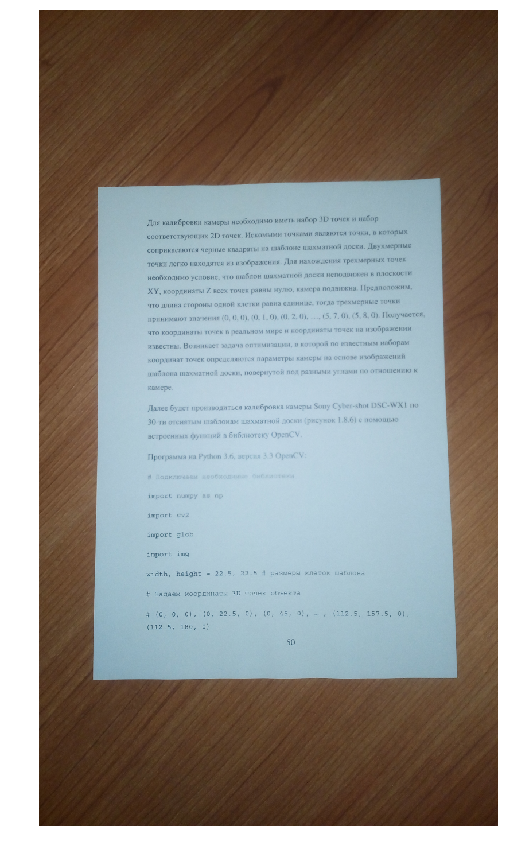

In [4]:
#image = cv2.imread("Images/doc1.jpg")
image = cv2.imread("Images/doc2.jpg")
orig = image.copy()
image = resize(orig, width = 800)
ratio = orig.shape[1] / image.shape[1]
imshow_plt(image)

In [5]:
def CannyBGR(image, T1, T2):
    image = cv2.GaussianBlur(image, (5, 5), 0)
    (B, G, R) = cv2.split(image)
    B = cv2.Canny(B, T1, T2)
    G = cv2.Canny(G, T1, T2)
    R = cv2.Canny(R, T1, T2)
    canny = cv2.bitwise_or(cv2.bitwise_or(B, G), R)
    return canny

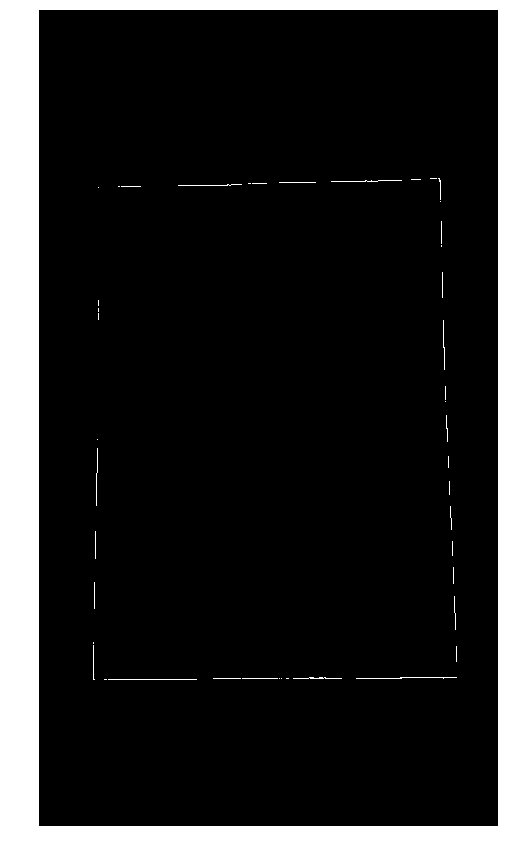

In [6]:
blurred = cv2.GaussianBlur(image, (5, 5), 0)
canny = CannyBGR(blurred, 75, 200)
imshow_plt_gray(canny)

In [7]:
cnts = cv2.findContours(canny, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[1]
cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:3]

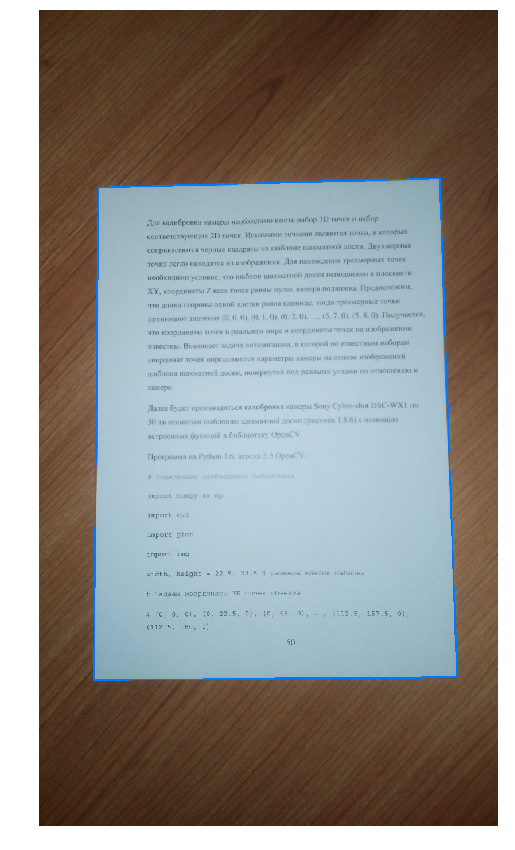

In [8]:
for cnt in cnts:
    curveLength = cv2.arcLength(cnt, True)
    eps = 0.02*curveLength
    approx = cv2.approxPolyDP(cnt, eps, True)
    if len(approx) == 4:
        contour = approx
        break
cv2.drawContours(image, [contour], -1, (255, 120, 0), 2)
imshow_plt(image)

In [9]:
def order_points(pts):
    rect = np.zeros((4, 2), dtype = "float32")
 
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
 
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    return rect

In [10]:
def perspective_transform(image, pts):
    rect = order_points(pts)
    (top_left, top_right, bottom_right, bottom_left) = rect
    
    widthA = np.sqrt(((bottom_right[0] - bottom_left[0])**2) +
                     ((bottom_right[1] - bottom_left[1])**2))
    widthB = np.sqrt(((top_right[0] - top_left[0])**2) + 
                     ((top_right[1] - top_left[1])**2))
    maxWidth = max(int(widthA), int(widthB))
    
    heightA = np.sqrt(((top_right[0] - bottom_right[0])**2) + 
                      ((top_right[1] - bottom_right[1])**2))
    heightB = np.sqrt(((top_left[0] - bottom_left[0])**2) + 
                      ((top_left[1] - bottom_left[1])**2))
    maxHeight = max(int(heightA), int(heightB))
    
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")

    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
 
    return warped

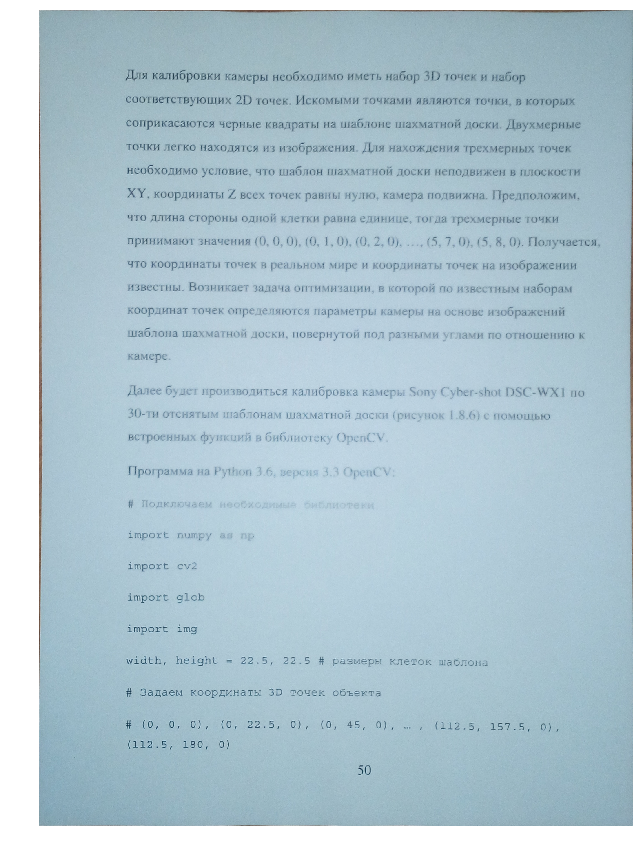

In [11]:
contour = contour.reshape(4, 2)
warped = perspective_transform(orig, contour*ratio)
imshow_plt(warped)

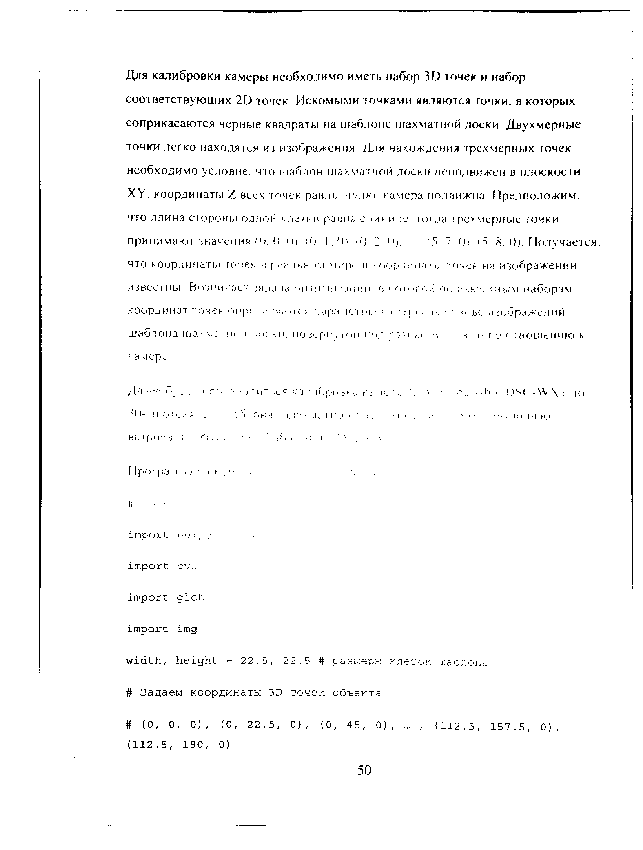

In [12]:
gray = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
T = mahotas.thresholding.otsu(gray)
gray[gray > 0.8*T] = 255
gray[gray < 255] = 0
imshow_plt_gray(gray)
imshow(gray)

In [13]:
#cv2.imwrite("Images/result1.jpg", gray)
cv2.imwrite("Images/result2.jpg", gray)

True